### Imports and functions

In [420]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pydicom as dicom 
import os
import SimpleITK as sitk
import math

from skimage import io, color
from skimage.util import img_as_float,img_as_ubyte
from skimage.morphology import erosion, dilation, opening, closing, disk
from skimage.transform import rescale, resize, rotate, EuclideanTransform, warp, AffineTransform, SimilarityTransform, swirl, matrix_transform
from skimage.filters import threshold_otsu, median, gaussian, prewitt_h,prewitt_v, prewitt
from skimage import measure
from skimage.color import label2rgb

from scipy.stats import norm
from scipy.spatial import distance

from sklearn import decomposition
from sklearn.decomposition import PCA


In [264]:
def plot_comparison(original, filtered, filter_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    io.show()

In [266]:
def show_comparison(original, transformed, transformed_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(transformed)
    ax2.set_title(transformed_name)
    ax2.axis('off')
    io.show()

In [224]:
def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

# Camera and Lenses

### How much data..?



- The frame rate is the amount of frames per second. For example 20 frames/s (measured in Hz)
- For video processing we have two frame rates
        
        – How many frames can the camera deliver per second
        
        – How many frames can we analyze per second
- The system frame rate is the minimum of the
camera and processing frame rate

**Test Exam - Video surveillance system**

You are developing a new surveillance system that consists of a camera connected to a computer using a USB-2 connection. The images are RGB (8-bits per channel) images with a size of 1600 x 800 pixels.  When you tested your system, you did some timings of your system. You found out that your image analysis algorithm takes 230 milliseconds to process one frame. You also found out that the camera can successfully send 6.25 images per second to the computer (this is an average value measured over a minute).


1. How much data can the USB-2 connection transfer from the camera to the computer on the system you tested?
2. What is the overall system framerate of your system (the maximum frame-per-second)?

In [353]:
image_bytes= 1600 * 800 * 3
bytes_to_mb = 1e-6

# MB per image  # mb
print("Total bytes per image: ", image_bytes)

# Algo time
time_to_process = 0.230 # seconds
algo_frame_rate = 1/time_to_process

# Camera time
camera_frame_rate = 6.25 # images per second

print("\nImages processed by the algo per second: ", algo_frame_rate, '(hz)')
print("Images send by the camera per second is : ", camera_frame_rate, '(hz)')
print("The bottleneck is the algorithm, so the system frame rate is", algo_frame_rate)

# Algo
print("\nMB processed by the algo per second: ", proc_pr_second * image_bytes * bytes_to_mb) 

# Camara
print("\nMB send by camera per second: ", camera_frame_rate * image_bytes * bytes_to_mb)



Total bytes per image:  3840000

Images processed by the algo per second:  4.3478260869565215 (hz)
Images send by the camera per second is :  6.25 (hz)
The bottleneck is the algorithm, so the system frame rate is 4.3478260869565215

MB processed by the algo per second:  16.695652173913043

MB send by camera per second:  24.0


# Video detection

### How many pixels are detected as changed?

Video change detection

You have developed a new video change detection system. To test if it works, you have acquired two images. One is the background (background.png) and  the second is a new frame (new_frame.png). They are both RGB images of size (600, 450).


Your algorithm works like this:

Converts both images to gray scale using color.rgb2gray. Both images are now floating point images where the pixel values are between 0 and 1.
Updates the background image by new_background = alpha * background + (1-alpha) * new_frame. Alpha = 0.90.
Computes the absolute difference image between the new frame and the new background.
Computes how many pixels in the difference image that have a value above 0.1. These are the changed pixels.

How many pixels are detected as changed?

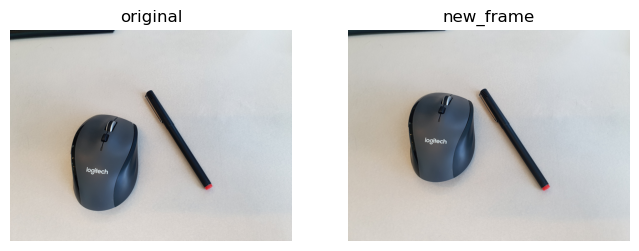

In [23]:
in_dir = "data/"
im_name = "background.png"
im_background = io.imread(in_dir + im_name)
im_name = "new_frame.png"
im_new_frame = io.imread(in_dir + im_name)
plot_comparison(im_background, im_new_frame, "new_frame")

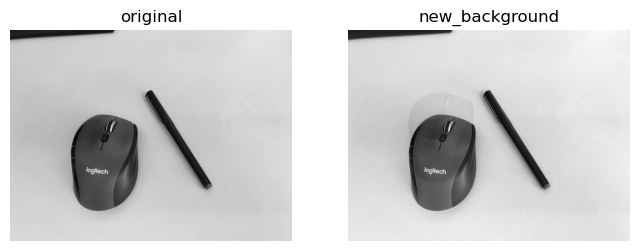

In [24]:
# Convert to grey
im_background = color.rgb2gray(im_background)
im_new_frame = color.rgb2gray(im_new_frame)

new_background = im_background * 0.9 + (1-0.9) * im_new_frame

plot_comparison(im_background, new_background, "new_background")

In [25]:
# Create a boolean mask where each pixel value is compared to 0.1
mask = new_background > 0.1

# Count the number of True values in the mask
num_pixels_above_0_1 = mask.sum()

print(num_pixels_above_0_1)

267564


**What is the average value of the estimated new background image in the pixel region [150:200, 150:200] ?**

In [28]:
np.mean(new_background[150:200, 150:200] )

0.602417740972549

# Morphology

### Character recognition

You would like to sort all your books and magazines by their title and you start by making a system that can recognize letters. 

To try to find the red letters, we first extract the R, G, B color channels from the image. Secondly we create a new binary image from the RGB image by setting all pixel with R > 100 and G < 100 and B < 100 to 1 and the remaining pixels to 0.

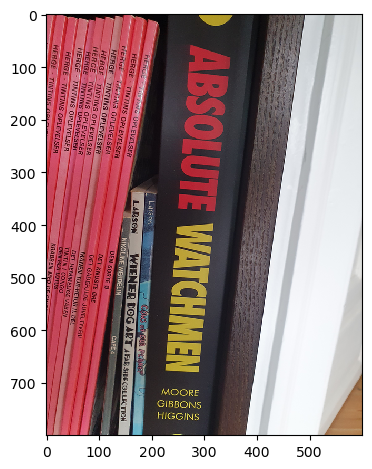

In [246]:
in_dir = 'data/'
im_org = io.imread(f'{in_dir}Letters.png')
io.imshow(im_org)
io.show()

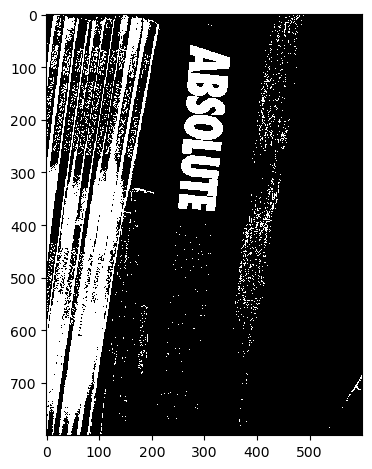

In [245]:
r_comp = im_org[:, :, 0]
g_comp = im_org[:, :, 1]
b_comp = im_org[:, :, 2]

rgb_filtered = (r_comp > 100) & (g_comp < 100) & (b_comp < 100)
rgb_filtered = img_as_ubyte(rgb_filtered)

io.imshow(rgb_filtered)

1. The binary image is eroded busing a disk shaped structuring element with radius=3. How many foreground pixels are there in the eroded image?

In [247]:
footprint = disk(3)
eroded = erosion(rgb_filtered, footprint)
mask = eroded.astype(bool)
mask.sum()

36073

You would like to pre-process the image before the analysis and you try with the following approach:

 

* Convert the input photo from RGB to gray scale
* Apply a median filter to the gray scale image with a square footprint of size  8
 

2. What is the value at the pixel at (100, 100) in the resulting image?

 

In [252]:
img_gray = color.rgb2gray(im_org)
weights = np.ones([8, 8])
median_filtered = median(img_gray, weights)
median_filtered[100,100]

0.44944431372549015

To try to find the letters, we perform the following operation:

* Compute a binary image where the pixels that has an RGB value with R>100 and G<100 and B<100 are set to 1 and the rest of the pixels to 0
* Erode the binary binary image using a disk-shaped structuring element with radius=3
* Compute all the BLOBs in the image
* Computes the area and perimeter of all found BLOBs
* Remove all BLOBs with an area<1000 or an area>4000 or a perimeter<300 
 

3. What letters are left in the photo after these operations?

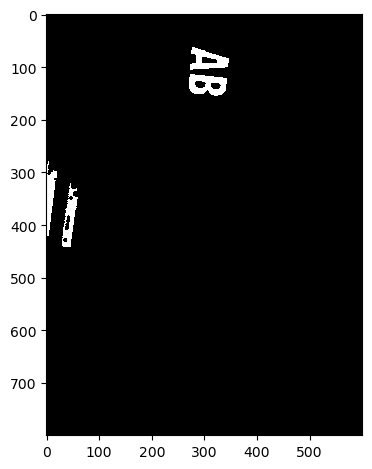

In [253]:
min_area = 1000
max_area = 4000
min_peri = 300

label_img = measure.label(eroded)
region_props = measure.regionprops(label_img)
label_img_filter = label_img

areas = np.array([prop.area for prop in region_props])
perimeters = np.array([prop.perimeter for prop in region_props])
counter = 0

for region in region_props:
    if region.area > max_area or region.area < min_area or region.perimeter < min_peri:
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0

i_area = label_img_filter > 0
io.imshow(i_area)

### Pixelwise operations
You are testing a prototype of a system that can monitor car parking areas. In order to
locate the cars you want to create a binary image. Your algorithm does:
1. Converts the input image from RGB to gray scale and transforms it into a floating
point image.
2. Does a linear gray scale transformation so the transformed image has a minimum
pixel value of 0.1 and a maximum pixel value of 0.6
3. Computes a pixel value threshold using Otsu's method
4. Applies the found threshold, so all pixels with values above the threshold
becomes foreground (white) and the rest background (black).


In [454]:
# Load image
im_org = io.imread('data02/' + 'pixelwise.png')

# Convert to grey
im_org = color.rgb2gray(im_org)

# To ubyte
im_org = img_as_float(im_org)

# Otsu threshold
thresh = threshold_otsu(image=im_org)
bin_img = im_org <= thresh

In [480]:
def histogram_stretch(img_in):
    """
    Stretches the histogram of an image 
    :param img_in: Input image
    :return: Image, where the histogram is stretched between min_desired and max_desired
    """

    img_float = img_in#img_as_float(img_in)
    min_val = img_float.min()
    max_val = img_float.max()
    min_desired = 0.1
    max_desired = 0.6
    
    for i in range(0, img_float.shape[0]):
        for j in range(0,img_float.shape[1]):
            val = img_float[i][j]
            img_float[i][j] = (max_desired - min_desired) / (max_val-min_val) * (val - min_val) + min_desired
    
    return img_float

0.3724609375


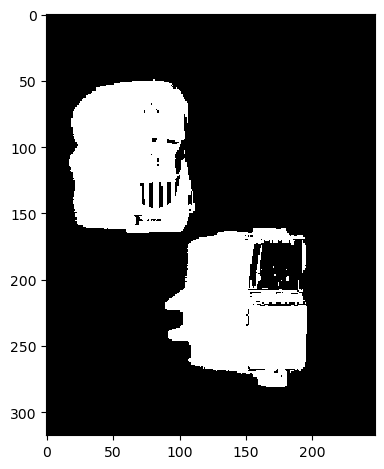

In [486]:
histogram_stretched = histogram_stretch(im_org)
thresh = threshold_otsu(image=histogram_stretched)
bin_img = im_org <= thresh
print(thresh)
io.imshow(bin_img)

## What is the number of foreground pixels..

### Product names on boxes

A customer has asked you to help them to design a system that can recognize product brands on cardboard boxes:

- Converts the input image from RGB to HSV
- Creates a new image that only contains the H component of the **HSV image**
- Creates a binary image by setting all pixels with an H value of 0.3 < H < 0.7 to 1 and the rest of the pixels to 0
- Performs a morphological dilation with a disk shaped structuring element with radius=8 on the binary image.

What is the number of foreground pixels (value = 1) in the resulting image?

In [45]:
# Load image
im_org = io.imread('data/' + 'nike.png')

# Convert to grey
im_org = color.rgb2hsv(im_org)

# Get the hue component
h_img = im_org[:, :, 0]

# Create a binary image by setting all pixels with an H value of 0.3 < H < 0.7 to 1 and the rest of the pixels to 0
bin_img = np.logical_and(h_img > 0.3, h_img < 0.7).astype(np.uint8)

In [51]:
footprint = disk(8)
dilated = dilation(bin_img, footprint)
mask = dilated.astype(bool)
mask.sum()

58979

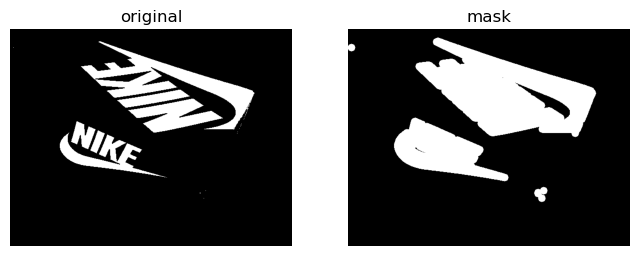

In [53]:
plot_comparison(bin_img, dilated, "mask")

### Concert light design

- Rotates the image 11 degrees with a rotation center of (40, 40).
- Transform the image from RGB to gray scale.
- Computes an automatic threshold using **Otsu's method**.
- Computes the percentage of foreground pixels.

What is the **percentage of foreground pixels** in the final image?

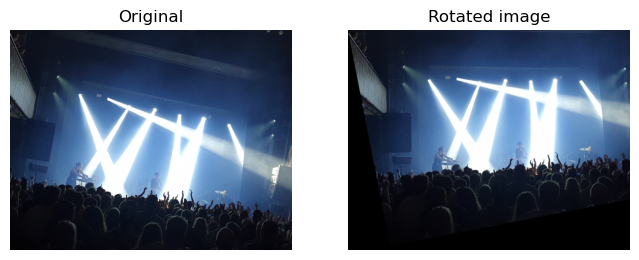

In [60]:
in_dir = 'data/'
im_org = io.imread(f'{in_dir}lights.png')
rotation_angle = 11
rot_center = [0, 0]
rotated_img = rotate(im_org, rotation_angle, center=rot_center)
show_comparison(im_org, rotated_img, "Rotated image")

In [73]:
gray_img = color.rgb2gray(rotated_img)
thresh = threshold_otsu(image=gray_img)
print('Otsu threshold:', thresh)
bin_img = gray_img <= thresh

mask = bin_img.astype(bool)
size = bin_img.size
print('The total size of the image:', size)
foreground = mask.sum()
print('The total size of the foreground:', foreground)
print('The percentage: ', foreground/size)

Otsu threshold: 0.419921875
The total size of the image: 499200
The total size of the foreground: 370934
The percentage:  0.743056891025641


# Dicom

### Abdominal CT analysis

In collaboration with a hospital, you want to investigate how the kidneys and the livers are related to the overall health status of a person. You do that by analyzing the appearance of the kidneys and the livers as seen computed tomography (CT) scans of the human abdominal area.

To test the approach, you use it on slice of a CT scan. It is a DICOM file called 1-166.dcm. You have also been given expert annotations of the liver (LiverROI.png), the left kidney (KidneyRoi_l.png) and the right kidney (KidneyRoi_r.png).

Your analysis pipeline consists of the following steps: 

- Read the DICOM file and the expert annotations
- Extract the pixel values of the liver, the left and the right kidney using the expert annotations
- Compute the average Hounsfield unit value in the left and the right kidney (too see if there is a functional difference)
- Compute the average and the standard deviation of the Hounsfield units in the liver
- Compute a threshold for the liver, t_1, that is the average liver Hounsfield unit minus the standard deviation
- Compute a threshold for the liver, t_2, that is the average liver Hounsfield unit plus the standard deviation
- Create a binary image by setting all pixels that have a  value that is between t_1 and t_2 to 1 and the rest to background.
- Dilate the binary image with a disk shaped kernel with radius=3
- Erode the binary image with a disk shaped kernel with radius=10
- Dilate the binary image with a disk shaped kernel with radius=10
- Extract all BLOBs in the binary image
- Compute the area and the perimeter of all BLOBs
- Remove all BLOBs with an area<1500 or an area>7000 or a perimeter<300
- Compute the DICE score between the estimated liver and the ground truth liver (LiverROI.png)
 

What are the Hounsfield unit limits used for segmentation of the liver?

1. Read the DICOM file and the expert annotations

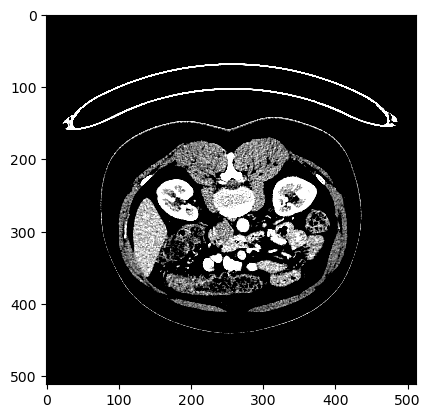

In [255]:
in_dir = "data/"
scan = dicom.read_file(in_dir + '1-166.dcm')
img = scan.pixel_array
plt.imshow(img, cmap="gray", vmin=0, vmax=100)
plt.show()


In [256]:
def load_mask(mask_path):
    roi = io.imread(mask_path)
    mask = roi > 0
    return mask

def get_values(img, mask_path):
    mask = load_mask(mask_path)
    return img[mask]

def get_gaussian_distributions(values, min_hu = -200, max_hu = 1000):
    hu_range = np.arange(min_hu, max_hu, 1.0)
    mu = np.mean(values)
    std = np.std(values)
    pdf = norm.pdf(hu_range, mu, std)
    return pdf


paths = ['KidneyRoi_l.png', 'KidneyRoi_r.png', 'LiverROI.png']

2. Extract the pixel values of the liver, the left and the right kidney using the expert annotations

In [257]:
values = [get_values(img, in_dir + path) for path in paths]

3. Compute the average Hounsfield unit value in the left and the right kidney (too see if there is a functional difference)

In [259]:
average_hou_kidney_l = np.mean(values[0])
average_hou_kidney_r = np.mean(values[1])
print("Average HU for left kidney: ", average_hou_kidney_l)
print("Average HU for right kidney: ", average_hou_kidney_r)    

Average HU for left kidney:  107.45075421472937
Average HU for right kidney:  107.56182572614108


4. Compute the average and the standard deviation of the Hounsfield units in the liver
5. Compute a threshold for the liver, t_1, that is the average liver Hounsfield unit minus the standard deviation
6. Compute a threshold for the liver, t_2, that is the average liver Hounsfield unit plus the standard deviation

In [272]:
mu_liver = np.mean(values[2])
std_liver = np.std(values[2])
t_1 = mu_liver - std_liver
t_2 = mu_liver + std_liver
print("T1: ", t_1)
print("T2: ", t_2)

T1:  51.7968823111612
T2:  100.87099317992372


7. Create a binary image by setting all pixels that have a  value that is between t_1 and t_2 to 1 and the rest to background.

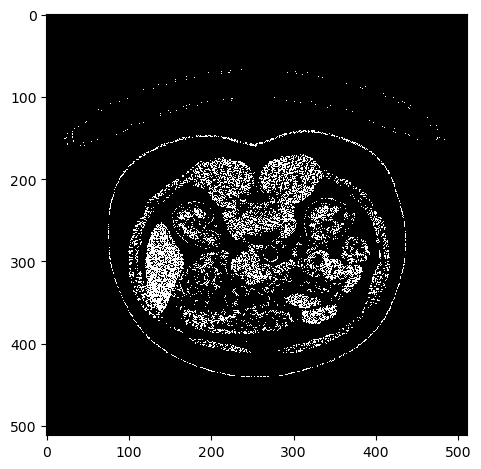

In [262]:
liver_thres = np.logical_and(img > t_1, img < t_2)
io.imshow(liver_thres)

8. Dilate the binary image with a disk shaped kernel with radius=3
9. Erode the binary image with a disk shaped kernel with radius=10
10. Dilate the binary image with a disk shaped kernel with radius=10
11. Extract all BLOBs in the binary image
12. Compute the area and the perimeter of all BLOBs
13. Remove all BLOBs with an area<1500 or an area>7000 or a perimeter<300
14. Compute the DICE score between the estimated liver and the ground truth liver (LiverROI.png)

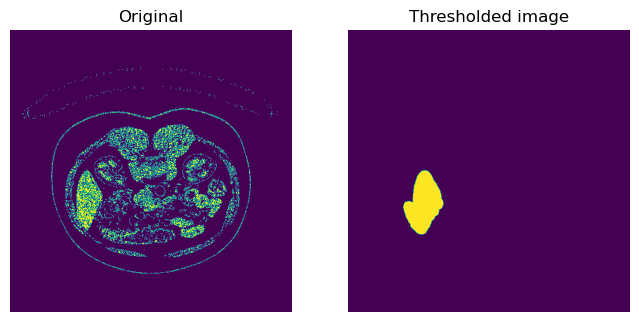

In [268]:
bin_img = liver_thres
footprint = disk(3)
dilated = dilation(bin_img, footprint)
footprint = disk(10)
eroded = erosion(dilated, footprint)
dilated = dilation(eroded, footprint)

min_area = 1500
max_area = 7000
min_peri = 300

label_img = measure.label(dilated)
region_props = measure.regionprops(label_img)
# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
    # Find the areas that do not fit our criteria
    if region.area > max_area or region.area < min_area or region.perimeter < min_peri:
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(liver_thres, i_area, 'Thresholded image')

In [271]:
def DICE_score(i_area, ground_truth_img):
    i_area = i_area
    gt_bin = ground_truth_img > 0
    dice_score = 1 - distance.dice(i_area.ravel(), gt_bin.ravel())
    return dice_score

ground_truth_img = io.imread(in_dir + 'LiverROI.png')
dice_score = DICE_score(i_area, ground_truth_img)
dice_score

0.782588123964987

# Landmarks

## Scale of similarity

### Shoe comparison

* Do a landmark based registration of shoe_1.png (the source) to shoe_2.png (the destination) using a similarity transform.
* Extract the found scale of the transform (using for example tform.scale ).
* Compare the values of the alignment error, F (sum of squared distances), before and after the registration.
* Compare the value of the blue component of the colors values of the aligned images.
 

1. What is the **scale of the similarity transform** after it has been estimated?

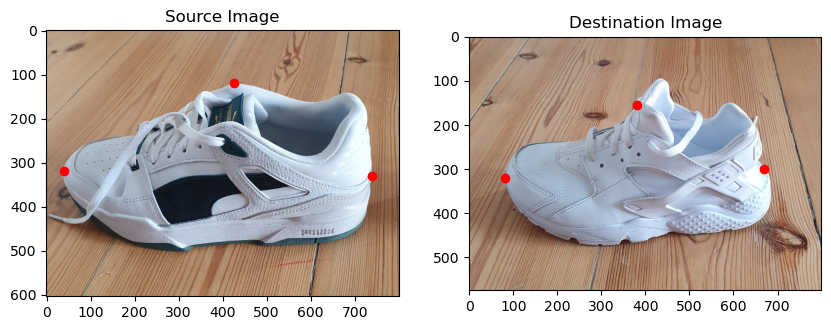

In [71]:
%matplotlib inline
src_img = io.imread(f'{in_dir}shoe_1.png')
dst_img = io.imread(f'{in_dir}shoe_2.png')

# Define points
src = np.array([[40, 320], [425, 120], [740, 330]]) 
dst = np.array([[80, 320], [380, 155], [670, 300]])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(src_img)
axs[0].plot(src[:, 0], src[:, 1], '.r', markersize=12)
axs[0].set_title('Source Image')

axs[1].imshow(dst_img)
axs[1].plot(dst[:, 0], dst[:, 1], '.r', markersize=12)
axs[1].set_title('Destination Image')

plt.show()


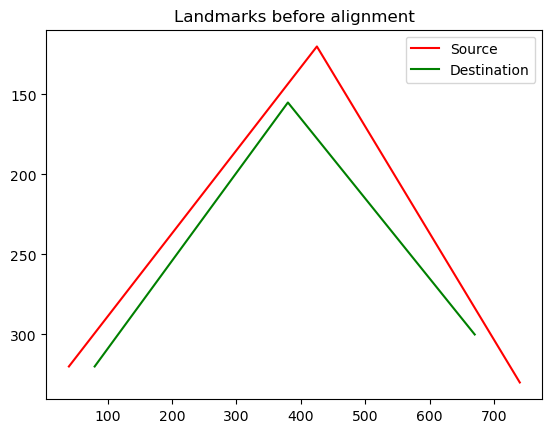

In [72]:
fig, ax = plt.subplots()
ax.plot(src[:, 0], src[:, 1], '-r', markersize=12, label="Source")
ax.plot(dst[:, 0], dst[:, 1], '-g', markersize=12, label="Destination")
ax.invert_yaxis()
ax.legend()
ax.set_title("Landmarks before alignment")
plt.show()

In [67]:
e_x = src[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)
e_y = src[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)
f_before = error_x + error_y
print(f"Landmark alignment error F_before: {f_before}")

Landmark alignment error F_before: 10650


In [55]:
tform = SimilarityTransform()
tform.estimate(src, dst)
src_transform = matrix_transform(src, tform.params)
src_transform

array([[ 78.96488773, 327.99975659],
       [389.63670663, 143.61437352],
       [661.39840565, 303.3858699 ]])

In [57]:
tform.scale

0.8327055808649095

After the transformation

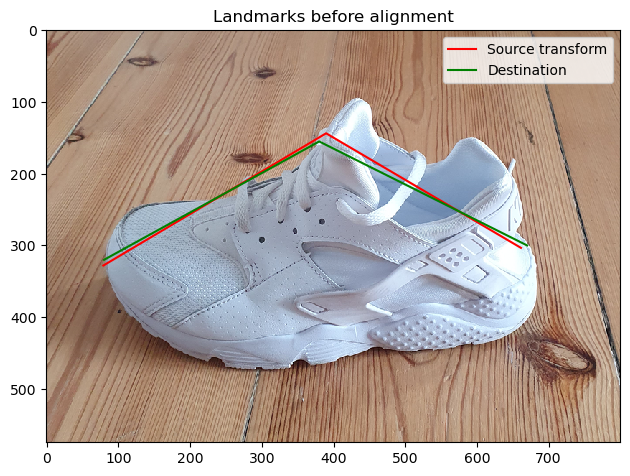

In [58]:
fig, ax = plt.subplots()
io.imshow(dst_img)
ax.plot(src_transform[:, 0], src_transform[:, 1], '-r', markersize=12, label="Source transform")
ax.plot(dst[:, 0], dst[:, 1], '-g', markersize=12, label="Destination")
#ax.invert_yaxis()
ax.legend()
ax.set_title("Landmarks before alignment")
plt.show()

In [63]:
e_x = src_transform[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)
e_y = src_transform[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)
f_after = error_x + error_y
print(f"Landmark alignment error F: {f_after}")

Landmark alignment error F: 373.01770826994596


2. What is the change of the landmark **alignment error F**, when comparing it before and after the transformation?

In [64]:
f_before-f_after

10276.982291730053

3. After the source photo has been transformed (using tform.inverse) both the transformed image and the destination image are converted to bytes using img_as_ubyte. Finally, the blue component of both images are extracted at position (200, 200). What is the absolute difference between these values?

In [75]:
warped = warp(src_img, tform.inverse)

src_inverse_ubyte = img_as_ubyte(warped)
dst_ubyte = img_as_ubyte(dst_img)


In [84]:
blue_src = src_inverse_ubyte[200,200,2].astype(np.int16)
blue_dst = dst_ubyte[200,200,2].astype(np.int16)
blue_diff = blue_src - blue_dst
print("Value of blue channel in source image: ", blue_src)
print("Value of blue channel in destination image: ", blue_dst)
print("Difference: ", blue_diff)

Value of blue channel in source image:  113
Value of blue channel in destination image:  139
Difference:  -26


# PCA

### Forensic glass analysis

To remove redundancy, we start by performing a Principal Component Analysis (PCA) of the data.  The measurements are scaled before computing the covariance matrix and the PCA by:

1) Subtract the mean from the data

2) Compute the minimum and maximum value of each measurement (for example the minimum and maximum Calcium content).

3) Divide each measurement by the difference between the maximum and the minimum value of that type of measurement (Calcium content is divided by the maximum-minimum calcium content)


In [181]:
data = np.loadtxt('data' + '/glass_data.txt', comments="%")
df = pd.DataFrame(data, columns=['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe'])

In [182]:
# Subtract the mean
df = df - df.mean()

In [183]:
# Divide each measurement by the difference between the 
# maximum and the minimum value of that type of measurement 

for col in df.columns:
    max = df[col].max()
    min = df[col].min()
    diff = max - min
    for row in df.index:
        df[col][row] = df[col][row]/diff

----- BY SKLEARN -----

In [195]:
pca = PCA()
pca.fit(df)
X = pca.transform(df)

In [197]:
np.abs(X).max()

1.1211053359943706

---- BY HAND -----

In [187]:
# Back to numpy after preprocessing
data = df.values

# Find covariance matrix
c_x_np = np.cov(data.T)

# Calculate eigenvalues and eigenvectors (PC components)
values, vectors = np.linalg.eig(c_x_np)

# Project data onto PC space
pc_proj = vectors.T.dot(data.T)

1. After the PCA analysis, the **data is projected onto the principal components**. The absolute value is then computed off all the projected values and the maximum absolute value is found. What is this value?

In [189]:
np.abs(pc_proj).max()

1.1211053359943874

2. When the PCA has been computed, we compute how much each component explain of the total variation. How much of the **total variation is explained by the first three components**?

Variance of first three components: 76.06912558548669


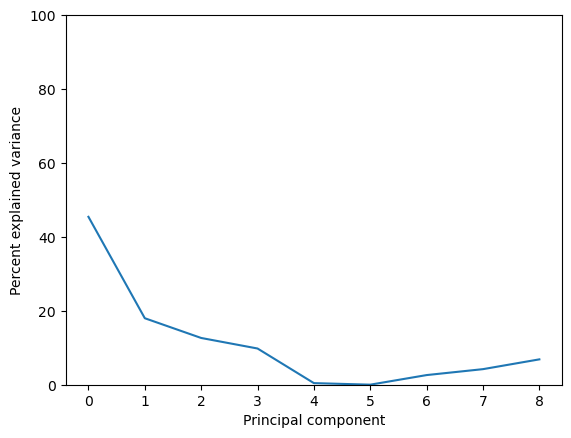

In [191]:
v_norm = values / values.sum() * 100
plt.plot(v_norm)
plt.xlabel('Principal component')
plt.ylabel('Percent explained variance')
plt.ylim([0, 100])
print('Variance of first three components:', v_norm[:3].sum())
plt.show()



3. **The covariance matrix** is computed before doing the PCA. What is the value of the diagonal matrix at position (0, 0) ?

In [193]:
c_x_np[0][0]

0.017772281053790955

4. What is the first value of the Sodium (Na) measurements after subtraction of the mean and scaling?

In [194]:
df['Na']

0      0.034910
1      0.072504
2      0.018368
3     -0.029752
4     -0.020729
         ...   
209    0.110098
210    0.227391
211    0.143180
212    0.146188
213    0.123632
Name: Na, Length: 214, dtype: float64

### PizzAI - PCA Images

A pizza startup, PizzAI, wants to use machine learning to match customer taste to the optimal pizza. They have provided you with ten training photos of their current selection of pizzas.  You start by using image based principal component analysis to make a statistical model of the visual appearance of the pizzas in the training set.

You start by computing the average pizza and then you use PCA from sklearn.decomposition to compute 5 principal components of the 10 images.

In [358]:
image_names =  []
for image in os.listdir('data/training/'):
    image_names.append(image)

In [359]:
training_images = []
in_dir = 'data/training/'
for i in image_names:
    file = io.imread(f'{in_dir}/'+ f'{i}')
    height, width, channels = file.shape    
    training_images.append((file).flatten())

    
print("height:", height, "  width:", width, "  channels:", channels)

height: 300   width: 300   channels: 3


In [360]:
# Mean pizza
mean_img = np.mean(training_images, axis=0)

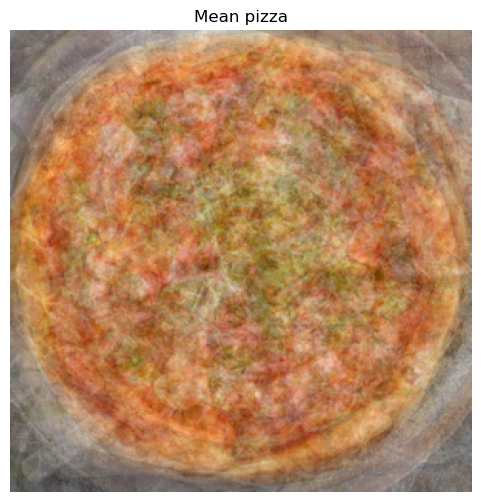

In [361]:
average_img = create_u_byte_image_from_vector(mean_img, height, width, channels)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.imshow(average_img)
ax.set_title("Mean pizza")
ax.set_axis_off()
plt.show()

1. The company has asked you to compute a measure of the variation on their menu. After doing the PCA, you compute how much the first principal component explains of the total variation. It is: 

In [362]:
pca = PCA()
pca.fit(training_images)
values_pca = pca.explained_variance_ratio_[:3]
values_pca

array([0.23082787, 0.13933354, 0.12320351])

2. One of your friends is an experimental eater and wants to taste the pizza that is visually as far away from the average pizza as possible. You compare all pizzas with the average pizza and select the one which has the largest sum of squared differences compared to the average pizza. Which pizza do you serve for your friend?

In [363]:
sub_data = training_images - mean_img.flatten()
sub_distances = np.linalg.norm(sub_data, axis=1)
biggest_idx = sub_distances.argmax()
smallest_idx = sub_distances.argmin()
print("Futhest away from the average pizza:", image_names[biggest_idx])
print("Closest to the aveage pizza:", image_names[smallest_idx])


Futhest away from the average pizza: BigSausage.png
Closest to the aveage pizza: Leafy.png


3. The company has asked you to define their signature pizzas. The ones that are most varied. After computing the PCA, you project all pizzas on to the PCA space.  You find the two pizzas that are the furthest away on the first principal axes. One in the positive and one in the negative direction. What pizzas do you suggest to be signature pizzas?

In [387]:
X = pca.transform(training_images)
pc_1, pc_2 = X[:, 0], X[:, 1]

In [388]:
sig1 = image_names[pc_1.argmax()]
sig2 = image_names[pc_1.argmin()]
print("The two most significant images are:", sig1, "and", sig2)

The two most significant images are: BigSausage.png and FindTheOlives.png


4. An international student at DTU, is missing his favorite pizza.  The student has asked his family to send him a photo (super_pizza.png) of this amazing pizza. Which pizza on the PizzAI menu looks most similar to this pizza. You find the solution by projecting the photo of the wanted pizza on to PCA space and finding the closest menu pizza in PCA space. Which pizza is that?

In [392]:
super_pizza = io.imread("data/super_pizza.png")
super_pizza_flat = (super_pizza.flatten()).reshape(1, -1)
pca_coords = pca.transform(super_pizza_flat)
pca_coords = pca_coords.flatten()

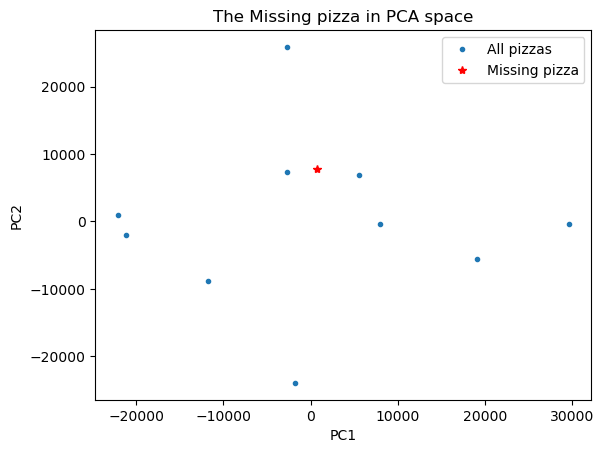

In [401]:
plt.plot(pc_1, pc_2, '.', label="All pizzas")
plt.plot(pca_coords[0], pca_coords[1], "*", color="red", label="Missing pizza")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("The Missing pizza in PCA space")
plt.legend()
plt.show()

With 2 components

In [408]:
dist = []
for i in zip(pc_1,pc_2):
    dist.append(distance.euclidean(i, (pca_coords[0], pca_coords[1])))
    
print("The closest pizza is:", image_names[np.argmin(dist)])

The closest pizza is: GreenHam.png


With 5 components

In [418]:
dist_try2 = []
for i in X:
    dist_try2.append(distance.euclidean(i[:5], pca_coords[:5]))
    
np.argmin(dist_try2)

4

With all components

In [412]:
comp_sub = X - pca_coords
pca_distances = np.linalg.norm(comp_sub, axis=1)
np.argmin(pca_distances)

5

# Advanced 3D image registration

### Advanced 3D image registration

You are using SimpleITK to register one image to another image.


First you try to apply the following steps to the moving image:

 

Apply a 30 degrees roll.
Translate 10 units in the X direction.
Apply a 10 degrees yaw.
 

1. You combine these transformations into an affine transformation matrix. What is this matrix? 

In [280]:
import SimpleITK as sitk
import numpy as np

# Create a 3D affine transformation
transform = sitk.AffineTransform(3)

# Set the rotation (roll and yaw)
roll = np.deg2rad(30)
yaw = np.deg2rad(10)
rotation_matrix = np.array([[np.cos(roll)*np.cos(yaw), -np.sin(roll), np.cos(roll)*np.sin(yaw)],
                            [np.sin(roll)*np.cos(yaw), np.cos(roll), np.sin(roll)*np.sin(yaw)],
                            [-np.sin(yaw), 0, np.cos(yaw)]])

# Set the matrix
transform.SetMatrix(rotation_matrix.ravel())

# Set the translation
transform.SetTranslation([10, 0, 0])

# Print the transformation matrix
print("Affine transformation matrix:")
print(transform.GetMatrix())

Affine transformation matrix:
(0.8528685319524433, -0.49999999999999994, 0.1503837331804353, 0.49240387650610395, 0.8660254037844387, 0.08682408883346515, -0.17364817766693033, 0.0, 0.984807753012208)


# By hand exercises 

## Hough space

### Corresponding data points
The five data points (x, y): (7,13), (9,10), (6,10), (6,8), (3,6)
result in the corresponding five Hough space sinograms (curves in
Hough space) shown below.

Two Hough space sinograms are crossing at (rho = 0.29, theta = 151 ).

What are the corresponding data points for the two crossing curves in
Hough space? (approximately)

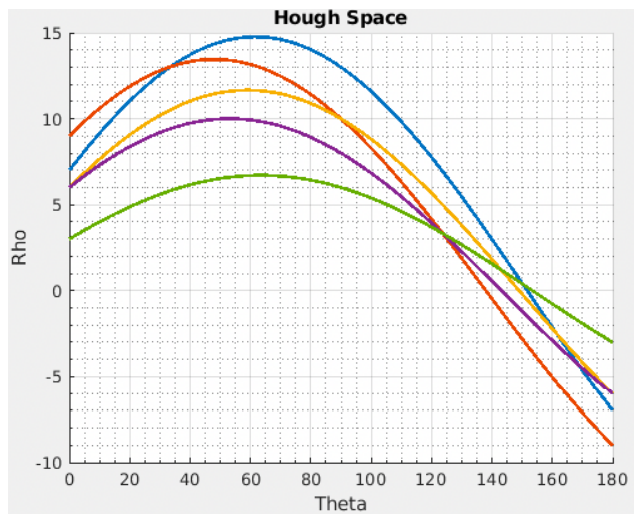

In [421]:
theta = 151
points = [(7,13), (9,10), (6,10), (6,8), (3,6)]

rho = []

for (x,y) in points:
    rho.append(x*np.cos(math.radians(theta)) + y*np.sin(math.radians(theta)))

rho

[0.18018711322661307,
 -3.0234811617911905,
 -0.39962204037300264,
 -1.3692412808656766,
 0.2849986000598359]

Red = (9,10)
Purple = (6,8)
Green = 
Yellow =
Blue =
... We can see on the image that it's the two lines furest away from 151, which would the the first and the last in the set of points

## Shortest path

### Accumulation
We are searching for the shortest path going from the top to the bottom
of the image below. You are using dynamic programming for the task
and as part of that you are computing an accumulator image. What is the
**minimal value of the last row of the computed accumulator image**?

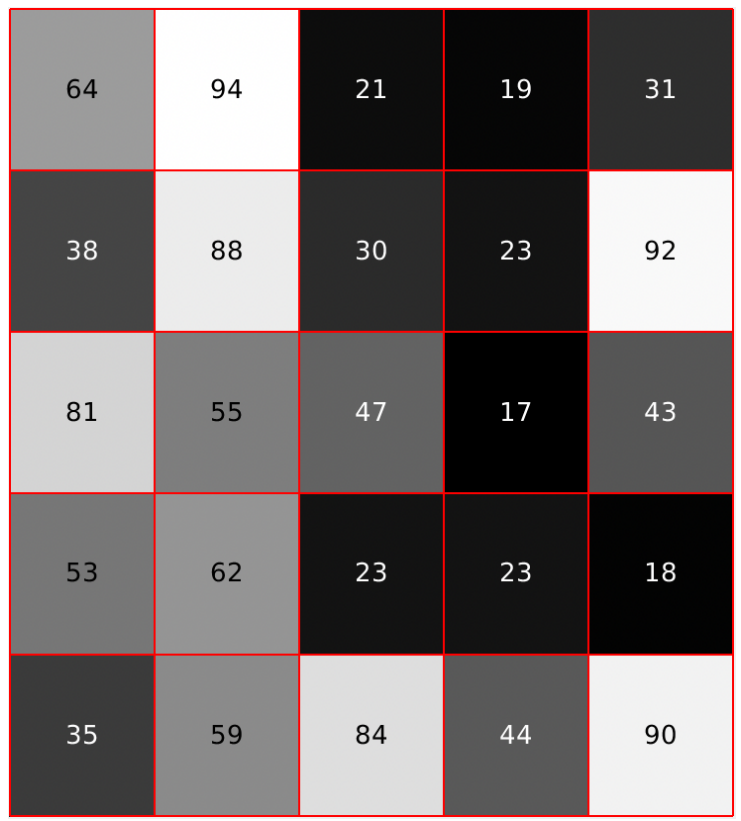


In [422]:
19+23+17+18+44

121

## Pixelwise

### Haar

**plus grey areas, minus white ones**

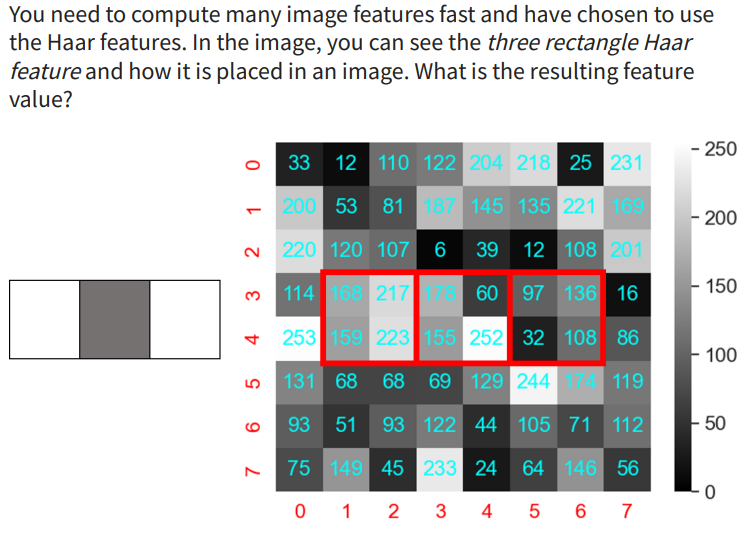

In [423]:
-168-217-159-223-97-136-32-108+178+60+155+252

-495

### Integral image

**Sum of all pixels to the left and on top, including the pixel itself**

What is the value of the integral image at the marked pixel?

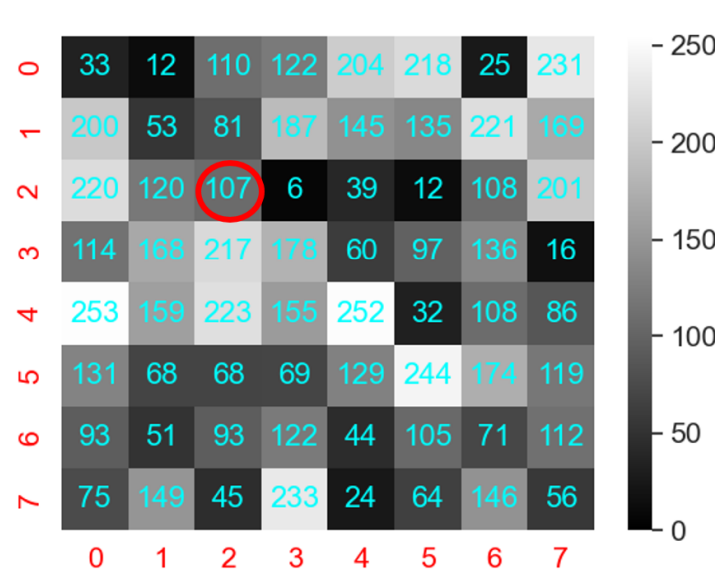

In [424]:
33+12+110+200+53+81+220+120+107

936